#### OpenCV Sudoku Solver

Nesse case vamos utilizar o OpenCV e Keras para montar um resolver automático de Sudoku. Primeiro vamos criar nossa rede neural que reconhece dígitos e treiná-la utilizando o dataset de dígitos. Então, vamos utilizar o openCV para extrair os dígitos de uma imagem de sudoku e passá-los para a rede neural treinada.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

width = numero de pixels na vertical

height = numero de pixels na horizontal

classes = numero de classes na predição (numeros 0 a 9)

depths = numero de canais


input_shape = (width, height, depth)

1-  layer de convolução com 32 filtros de tamanho 5x5, função ReLU, adicionar parametro padding = 'same'

2-  polling com (2,2)

3-  convolução com 32 filtros de tamanho 3x3, função relu, parametro padding = 'same'

4-  polling com (2,2)

5-  flatten

6-  layer denso com 64 nós, Relu com dropout: basta fazer model.add(Dropout(0.5))


model.add(Dense())

model.add(Dropout(0.5))

7-  layer denso com 64 nós, Relu com dropout: basta fazer model.add(Dropout(0.5))

8-  layer denso com 10 nós, softmax como ativação


In [3]:
# Crie um função que recebe como argumeto width, height, depth, classes 

def build(width, height, depth, classes):
    model = Sequential()
    model.add(Conv2D(32, (5,5), input_shape = (width, height, depth), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(classes, activation='softmax'))

    return model

build(28,28,1,10).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 64)                1

#### Treinando o modelo

In [4]:
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer

In [5]:
((train_data, train_labels), (test_data, test_labels)) = mnist.load_data()

11501568/11490434 [==============================] - 11s 1us/step


In [6]:
train_data.shape

(60000, 28, 28)

In [7]:
### fazer um reshape de train_data e test_data de (train_data.shape[0], 28, 28) para (train_data.shape[0], 28, 28, 1).

train_data = train_data.reshape((train_data.shape[0], 28, 28, 1))
test_data = test_data.reshape((test_data.shape[0], 28, 28, 1))

### transformar todo mundo entre 0 e 1 (train_data, test_data)

train_data = train_data/255.0
test_data = test_data/255.0


### converta os labels para vetores. Use LabelBinarizer().
# para usar user  .fit_transform(train_labels). Salve na mesma variável.

le = LabelBinarizer()
train_labels = le.fit_transform(train_labels)
test_labels = le.fit_transform(test_labels)


In [8]:
model = build(width = 28, height=28, depth=1, classes=10)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

history = model.fit(train_data, train_labels, validation_data = (test_data, test_labels), batch_size = 128, epochs = 10, verbose = True)

Epoch 1/10
469/469 [==============================] - 83s 172ms/step - loss: 0.7422 - accuracy: 0.7507 - val_loss: 0.0906 - val_accuracy: 0.9746
Epoch 2/10
469/469 [==============================] - 74s 158ms/step - loss: 0.2915 - accuracy: 0.9108 - val_loss: 0.0660 - val_accuracy: 0.9803
Epoch 3/10
469/469 [==============================] - 83s 177ms/step - loss: 0.2213 - accuracy: 0.9322 - val_loss: 0.0452 - val_accuracy: 0.9865
Epoch 4/10
469/469 [==============================] - 88s 187ms/step - loss: 0.1844 - accuracy: 0.9445 - val_loss: 0.0448 - val_accuracy: 0.9867
Epoch 5/10
469/469 [==============================] - 96s 204ms/step - loss: 0.1616 - accuracy: 0.9522 - val_loss: 0.0475 - val_accuracy: 0.9863
Epoch 6/10
469/469 [==============================] - 87s 185ms/step - loss: 0.1481 - accuracy: 0.9557 - val_loss: 0.0393 - val_accuracy: 0.9887
Epoch 7/10
469/469 [==============================] - 87s 186ms/step - loss: 0.1368 - accuracy: 0.9595 - val_loss: 0.0370 - val_ac

#### Salvar o modelo

In [9]:
model.save('meu_modelo', save_format = 'h5')

#### Identificar o sudoku na imagem

In [12]:
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

In [13]:
image = cv2.imread('sudoku.png')

def find_puzzle(image):
    #salvar em uma variável chamada 'gray' a imagem convertida para preto e banco

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #salvar em uma variável 'blurred' a imagem após aplicar GaussianBlur com parâmetros (7,7) e 3

    blurred = cv2.GaussianBlur(gray, (7,7), 3)

    #aplicar na imagem blurred um threshold adaptativo. Usar o thereshold adaptativo gaussiano (cv2.ADAPTIVE_THRESH_GAUSSIAN_C) com cv2.THRESH_BINARY com parâmetros 11 e 2 
    #inverter a imagem usando bitwise_not

    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    thresh = cv2.bitwise_not(thresh)

    #usar a função findContours com o cv2.RETR_EXTERNAL e método de aproximação cv2.CHAIN_APROX_SIMPLE e salvar o retorno numa
    #variável cnts

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #usar a função imutils.grab_contours(cnts) e salvar o resultado em cnts

    cnts = imutils.grab_contours(cnts)

    cnts = sorted(cnts, key = cv2.contourArea, reverse=True)

    puzzle_cnt = None

    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02*peri, True)

        if len(approx) == 4:
            puzzle_cnt = approx
            break
    
    if puzzle_cnt is None:
        raise(Exception('Não foi encontrado nenhum contorno!'))


    #aplique a four_point_transform na imagem cinza e na imagem colorida. Lembrete precisamos trocar o shape de puzzle_cnt
    #(2, 4) -> (4,2) 
    #a função recebe a imagem, e os pontos e retorna a imagem com outra perspectiva
    
    puzzle = four_point_transform(image, puzzle_cnt.reshape(4,2))
    warped = four_point_transform(gray, puzzle_cnt.reshape(4,2))

    return(puzzle, warped)



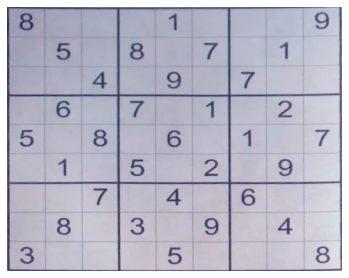

In [14]:
image = cv2.imread('sudoku.png')

img_warped, img_gray_warped = find_puzzle(image)

plt.figure(figsize=(6,6))
plt.imshow(img_warped)
plt.axis('off')
plt.show()

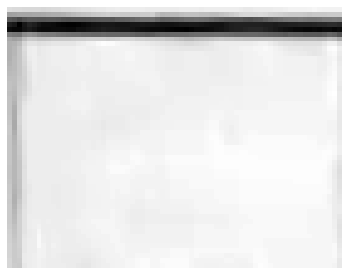

In [15]:
step_x = img_gray_warped.shape[1] // 9
step_y = img_gray_warped.shape[0] // 9

begin_x = (step_x)*1
begin_y = 0

end_x = begin_x + step_x
end_y = begin_y + step_y

cell = img_gray_warped[begin_y:end_y, begin_x:end_x]

plt.figure(figsize=(6,6))
plt.imshow(cell, cmap = 'gray')
plt.axis('off')
plt.show()

test_cell = cell

In [16]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [17]:
from skimage.segmentation import clear_border

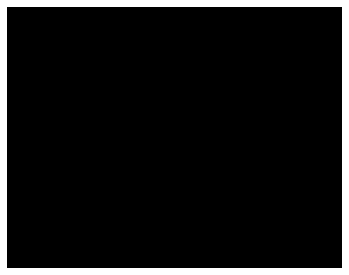

In [32]:
thresh = cv2.threshold(test_cell, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

thresh_clear = clear_border(thresh)

plt.figure(figsize=(6,6))
plt.imshow(thresh_clear, cmap = 'gray')
plt.axis('off')
plt.show()

In [19]:
def extract_digit(cell):
    thresh = cv2.threshold(cell,0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        return None
    
    c = max(cnts, key = cv2.contourArea)

    mask = np.zeros(thresh.shape, dtype = 'uint8')

    cv2.drawContours(mask, [c], -1, 255, -1)

    (h, w) = thresh.shape

    percent_filled = cv2.countNonZero(mask) / float(w*h)

    if percent_filled < 0.03:
        return None

    digit = cv2.bitwise_and(thresh, thresh, mask = mask)


    return digit


In [20]:
digit = extract_digit(test_cell)
type(digit)
# plt.figure(figsize=(6,6))
# plt.imshow(digit, cmap = 'gray')
# plt.axis('off')
# plt.show()

NoneType

In [22]:
from tensorflow.keras.preprocessing.image import img_to_array

In [23]:
image = cv2.imread('sudoku.png')
(puzzle_image, warped) = find_puzzle(image)

board = np.zeros((9,9), dtype = 'int')

step_x = warped.shape[1] // 9
step_y = warped.shape[0] // 9

cell_locs = []

for y in range(0,9):

    row = []

    for x in range(0,9):
        start_x = x*step_x
        start_y = y*step_y

        end_x = (x+1)*step_x
        end_y = (y+1)*step_y

        row.append((start_x, start_y, end_x, end_y))

        cell = warped[start_y:end_y, start_x:end_x]
        digit = extract_digit(cell)

        if digit is not None:
            img_to_predict = cv2.resize(digit, (28,28))
            img_to_predict = img_to_predict.astype('float') / 255.0
            img_to_predict = img_to_array(img_to_predict)
            np.expand_dims(img_to_predict, axis = 0)

            pred = model.predict(np.array([img_to_predict])).argmax(axis = 1)[0]

            board[y, x] = pred

    cell_locs.append(row)



In [24]:
for (cellRow, boardRow) in zip(cell_locs, board):

    for (box, digit) in zip(cellRow, boardRow):
        start_x, start_y, end_x, end_y = box

        textX = int((end_x - start_x) * 0.33)
        textY = int((end_y - start_y) * -0.2)
        textX += start_x
        textY += end_y

        cv2.putText(puzzle_image, str(digit), (textX, textY), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 4)





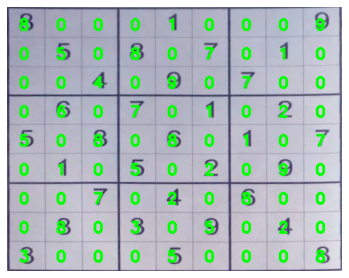

In [25]:
plt.figure(figsize=(6,6))
plt.imshow(puzzle_image)
plt.axis('off')
plt.show()

In [28]:
pip install py-sudoku

Note: you may need to restart the kernel to use updated packages.


In [29]:
from sudoku import Sudoku

In [30]:
puzzle = Sudoku(3, 3, board = board.tolist())
puzzle.show()

+-------+-------+-------+
| 8     |   1   |     9 |
|   5   | 8   7 |   1   |
|     4 |   9   | 7     |
+-------+-------+-------+
|   6   | 7   1 |   2   |
| 5   8 |   8   | 1   7 |
|   1   | 5   2 |   9   |
+-------+-------+-------+
|     7 |   2   | 8     |
|   8   | 3   5 |   2   |
| 3     |   5   |     8 |
+-------+-------+-------+



In [31]:
solution = puzzle.solve()
solution.show()

Puzzle has no solution
+-------+-------+-------+
|       |       |       |
|       |       |       |
|       |       |       |
+-------+-------+-------+
|       |       |       |
|       |       |       |
|       |       |       |
+-------+-------+-------+
|       |       |       |
|       |       |       |
|       |       |       |
+-------+-------+-------+

